In [ ]:
# Append the parent directory to the path
import os
import sys
sys.path.append(os.path.dirname(os.getcwd()))


# Import base packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
import pickle
from tqdm import tqdm

# Make the graphs pretty
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.rcParams.update({'font.size': 10, 'font.style': 'normal', 'font.family':'serif'})

In [1]:
# Import custom classes and functions
from environments.base import BaseEnvironment, SimpleBilateralEnvironment
from environments.contextual import ContextualEnvironment, OrderBookEnvironment 
from learners.experts import PartitionedContexts, ExploitNearestContext
from utils.regret import compute_scaling_laws, compute_scaling_laws_with_policy_regret
from utils.valuations import construct_sequence_with_lipschitz_valuations,\
    sinusoidal_function, triangle_wave_function, construct_sqrt_lower_bound,\
    easy_function

# Contextual Online Bilateral Trade - Full Feedback

## Lower bound sequence

In [5]:
T = 1000
L = 5
order_book, valuation_sequence = construct_sqrt_lower_bound(T, Lipschitz_constant=L)
env = OrderBookEnvironment(T, order_book, valuation_sequence)
algo = PartitionedContexts(T, env, L)
algo.run()

print(env.get_policy_gft_having_adhoc_valuations())
print(algo.get_final_gft())

100%|██████████| 1000/1000 [00:00<00:00, 193019.05it/s]

19.521250000000002
5.622119999999988


In [6]:
env = OrderBookEnvironment(T, order_book, valuation_sequence)
algo = ExploitNearestContext(T, env, L)
algo.run()

print(env.get_policy_gft_having_adhoc_valuations())
print(algo.get_final_gft())

100%|██████████| 999/999 [00:00<00:00, 16607.06it/s]

19.521250000000002
0


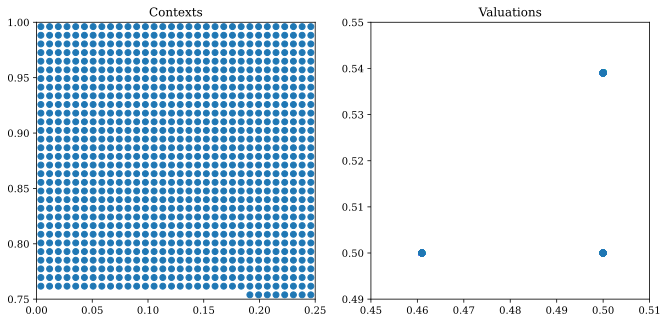

In [7]:
# plot contexts and valuations in two different plots side by side
fig, ax = plt.subplots(1, 2, figsize=(11, 5))
ax[0].scatter(order_book[:, 0], order_book[:, 1])
ax[0].set_ylim(0.75, 1)
ax[0].set_xlim(0, 0.25)
ax[0].set_title('Contexts')
ax[1].scatter(valuation_sequence[:, 0], valuation_sequence[:, 1])
ax[1].set_ylim(0.49, 0.55)
ax[1].set_xlim(0.45, 0.51)
ax[1].set_title('Valuations')
plt.show()

In [ ]:
time = np.linspace(10, 10000, 20, dtype=int)
L_constants = [5]

# Some cool parallel computation trick
def compute_regret():
    _, _, regret = compute_scaling_laws_with_policy_regret(
        PartitionedContexts, OrderBookEnvironment, time, L_constants, 
        construct_sqrt_lower_bound, Lipschitz_function=None
        )
    return regret

num_iterations = 100
pc_regrets = Parallel(n_jobs=-1)(delayed(compute_regret)() for _ in range(num_iterations))

In [9]:
# with open('../data/pc_lb.pkl', 'wb') as f: # pc_lb stands for Partitioned Contexts with Lower Bound
#     pickle.dump(pc_regrets, f)
with open('../data/pc_lb.pkl', 'rb') as f:
    pc_regrets = pickle.load(f)

# Transform to array
pc_regrets = np.array(pc_regrets).squeeze()
print(pc_regrets.shape)

(100, 20)


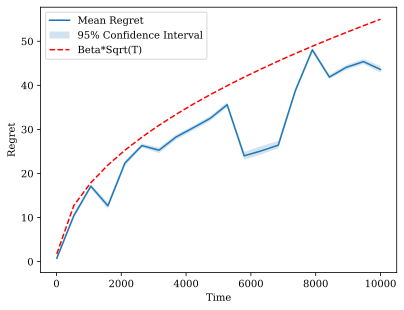

In [10]:
# Take the 2.5th percentile and 97.5th percentile
percentile_2_5 = np.percentile(pc_regrets, 2.5, axis=0)
percentile_97_5 = np.percentile(pc_regrets, 97.5, axis=0)

# Plot the mean regret and the 95% confidence interval
plt.plot(time, np.mean(pc_regrets, axis=0), label='Mean Regret')
plt.fill_between(time, percentile_2_5, percentile_97_5, alpha=0.2, label='95% Confidence Interval')
plt.xlabel('Time')
plt.ylabel('Regret')
#plt.title('Partitioned Contexts with Lower Bound Sequence, L=5')
# Plot sqrt(T) function in red
plt.plot(time, 0.55*np.sqrt(time), 'r--', label='Beta*Sqrt(T)')
plt.legend()
plt.show()

In [ ]:
time = np.linspace(10, 10000, 20, dtype=int)
L_constants = [5]

# Some cool parallel computation trick
def compute_regret():
    _, _, regret = compute_scaling_laws_with_policy_regret(
        ExploitNearestContext, OrderBookEnvironment, time, L_constants, 
        construct_sqrt_lower_bound, Lipschitz_function=None
        )
    return regret

num_iterations = 100
enc_regrets = Parallel(n_jobs=-1)(delayed(compute_regret)() for _ in range(num_iterations))

In [79]:
# with open('../data/enc_lb.pkl', 'wb') as f: # enc_lb stands for Exploit Nearest Context with Lower Bound
#     pickle.dump(enc_regrets, f)
with open('../data/enc_lb.pkl', 'rb') as f:
    enc_regrets = pickle.load(f)

# Transform to array
enc_regrets = np.array(enc_regrets).squeeze()
print(enc_regrets.shape)

(100, 20)


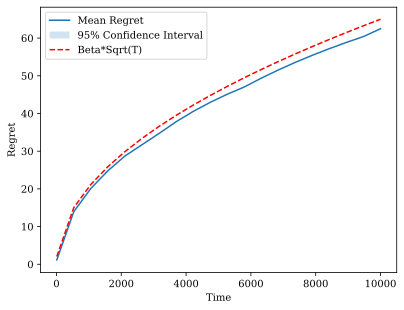

In [80]:
# Take the 2.5th percentile and 97.5th percentile
percentile_2_5 = np.percentile(enc_regrets, 2.5, axis=0)
percentile_97_5 = np.percentile(enc_regrets, 97.5, axis=0)

# Plot the mean regret and the 95% confidence interval
plt.plot(time, np.mean(enc_regrets, axis=0), label='Mean Regret')
plt.fill_between(time, percentile_2_5, percentile_97_5, alpha=0.2, label='95% Confidence Interval')
plt.xlabel('Time')
plt.ylabel('Regret')
#plt.title('Exploit Nearest Context with Lower Bound Sequence, L=5')
# Plot sqrt(T) function in red
plt.plot(time, 0.65*np.sqrt(time), 'r--', label='Beta*Sqrt(T)')
plt.legend()
plt.show()

## Hard Lipschitz Function (1)

In [11]:
T = 1000
L = 10
order_book, valuation_sequence = construct_sequence_with_lipschitz_valuations(
    T, Lipschitz_constant=L, Lipschitz_function=sinusoidal_function
    )
env = OrderBookEnvironment(T, order_book, valuation_sequence)
algo = PartitionedContexts(T, env, L)
algo.run()

print(env.get_policy_gft_having_adhoc_valuations())
print(algo.get_final_gft())

100%|██████████| 1000/1000 [00:00<00:00, 112270.24it/s]

80.55459341308104
52.68493435069129


In [12]:
env = OrderBookEnvironment(T, order_book, valuation_sequence)
algo = ExploitNearestContext(T, env, L)
algo.run()

print(env.get_policy_gft_having_adhoc_valuations())
print(algo.get_final_gft())

100%|██████████| 999/999 [00:00<00:00, 26361.51it/s]

80.55459341308104
52.358033013662386


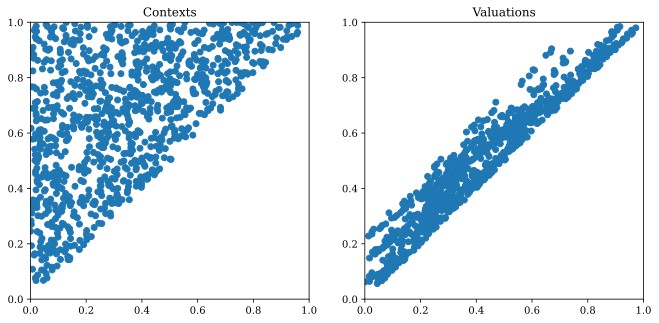

In [13]:
# plot contexts and valuations in two different plots side by side
fig, ax = plt.subplots(1, 2, figsize=(11, 5))
ax[0].scatter(order_book[:, 0], order_book[:, 1])
ax[0].set_ylim(0, 1)
ax[0].set_xlim(0, 1)
ax[0].set_title('Contexts')
ax[1].scatter(valuation_sequence[:, 0], valuation_sequence[:, 1])
ax[1].set_ylim(0, 1)
ax[1].set_xlim(0, 1)
ax[1].set_title('Valuations')
plt.show()

In [ ]:
time = np.linspace(10, 10000, 20, dtype=int)
L_constants = [5]

# Some cool parallel computation trick
def compute_regret():
    _, _, regret = compute_scaling_laws_with_policy_regret(
        PartitionedContexts, OrderBookEnvironment, time, L_constants, 
        construct_sequence_with_lipschitz_valuations, Lipschitz_function=sinusoidal_function
        )
    return regret

num_iterations = 100
pc_regrets = Parallel(n_jobs=-1)(delayed(compute_regret)() for _ in range(num_iterations))

In [77]:
# with open('../data/pc_sin.pkl', 'wb') as f: # pc_lb stands for Partitioned Contexts with Sinusoidal Valuations
#     pickle.dump(pc_regrets, f)
with open('../data/pc_sin.pkl', 'rb') as f:
    pc_regrets = pickle.load(f)

# Transform to array
pc_regrets = np.array(pc_regrets).squeeze()
print(pc_regrets.shape)

(100, 20)


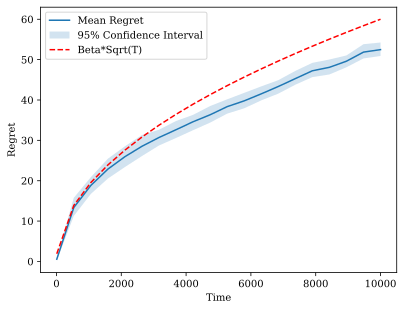

In [78]:
# Take the 2.5th percentile and 97.5th percentile
percentile_2_5 = np.percentile(pc_regrets, 2.5, axis=0)
percentile_97_5 = np.percentile(pc_regrets, 97.5, axis=0)

# Plot the mean regret and the 95% confidence interval
plt.plot(time, np.mean(pc_regrets, axis=0), label='Mean Regret')
plt.fill_between(time, percentile_2_5, percentile_97_5, alpha=0.2, label='95% Confidence Interval')
plt.xlabel('Time')
plt.ylabel('Regret')
#plt.title('Partitioned Contexts with Sinusoidal Function, L=5')
# Plot sqrt(T) function in red
plt.plot(time, 0.6*np.sqrt(time), 'r--', label='Beta*Sqrt(T)')
plt.legend()
plt.show()

Not bad! The partitioned contexts algorithm performs better than T^(2/3)

In [ ]:
time = np.linspace(10, 10000, 20, dtype=int)
L_constants = [5]

# Some cool parallel computation trick
def compute_regret():
    _, _, regret = compute_scaling_laws_with_policy_regret(
        ExploitNearestContext, OrderBookEnvironment, time, L_constants, 
        construct_sequence_with_lipschitz_valuations, Lipschitz_function=sinusoidal_function
        )
    return regret

num_iterations = 100
enc_regrets = Parallel(n_jobs=-1)(delayed(compute_regret)() for _ in range(num_iterations))

In [75]:
# with open('../data/enc_sin.pkl', 'wb') as f: # enc_lb stands for Exploit Nearest Context with Sinusoidal Valuations
#     pickle.dump(enc_regrets, f)
with open('../data/enc_sin.pkl', 'rb') as f:
    enc_regrets = pickle.load(f)

# Transform to array
enc_regrets = np.array(enc_regrets).squeeze()
print(enc_regrets.shape)

(100, 20)


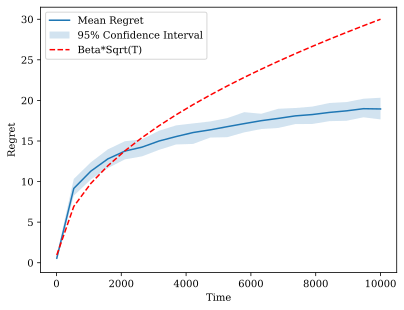

In [76]:
# Take the 2.5th percentile and 97.5th percentile
percentile_2_5 = np.percentile(enc_regrets, 2.5, axis=0)
percentile_97_5 = np.percentile(enc_regrets, 97.5, axis=0)

# Plot the mean regret and the 95% confidence interval
plt.plot(time, np.mean(enc_regrets, axis=0), label='Mean Regret')
plt.fill_between(time, percentile_2_5, percentile_97_5, alpha=0.2, label='95% Confidence Interval')
plt.xlabel('Time')
plt.ylabel('Regret')
#plt.title('Exploit Nearest Context with Sinusoidal Function, L=5')
# Plot sqrt(T) function in red
plt.plot(time, 0.3*np.sqrt(time), 'r--', label='Beta*Sqrt(T)')
plt.legend()
plt.show()

## Hard Lipschitz Function (2)

In [11]:
T = 1000
L = 10
order_book, valuation_sequence = construct_sequence_with_lipschitz_valuations(
    T, Lipschitz_constant=L, Lipschitz_function=triangle_wave_function
    )
env = OrderBookEnvironment(T, order_book, valuation_sequence)
algo = PartitionedContexts(T, env, L)
algo.run()

print(env.get_policy_gft_having_adhoc_valuations())
print(algo.get_final_gft())

100%|██████████| 1000/1000 [00:00<00:00, 164773.29it/s]

85.88554931602339
54.031987110518884


In [12]:
env = OrderBookEnvironment(T, order_book, valuation_sequence)
algo = ExploitNearestContext(T, env, L)
algo.run()

print(env.get_policy_gft_having_adhoc_valuations())
print(algo.get_final_gft())

100%|██████████| 999/999 [00:00<00:00, 33817.66it/s]

85.88554931602339
58.343061215884994


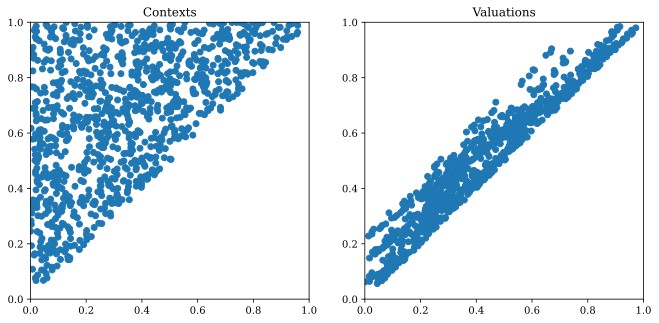

In [18]:
# plot contexts and valuations in two different plots side by side
fig, ax = plt.subplots(1, 2, figsize=(11, 5))
ax[0].scatter(order_book[:, 0], order_book[:, 1])
ax[0].set_ylim(0, 1)
ax[0].set_xlim(0, 1)
ax[0].set_title('Contexts')
ax[1].scatter(valuation_sequence[:, 0], valuation_sequence[:, 1])
ax[1].set_ylim(0, 1)
ax[1].set_xlim(0, 1)
ax[1].set_title('Valuations')
plt.show()

In [ ]:
time = np.linspace(10, 10000, 20, dtype=int)
L_constants = [5]

# Some cool parallel computation trick
def compute_regret():
    _, _, regret = compute_scaling_laws_with_policy_regret(
        PartitionedContexts, OrderBookEnvironment, time, L_constants, 
        construct_sequence_with_lipschitz_valuations, Lipschitz_function=triangle_wave_function
        )
    return regret

num_iterations = 100
pc_regrets = Parallel(n_jobs=-1)(delayed(compute_regret)() for _ in range(num_iterations))

In [73]:
# with open('../data/pc_tw.pkl', 'wb') as f: # pc_lb stands for Partitioned Contexts with Triangle Wave Valuations
#     pickle.dump(pc_regrets, f)
with open('../data/pc_tw.pkl', 'rb') as f:
    pc_regrets = pickle.load(f)

# Transform to array
pc_regrets = np.array(pc_regrets).squeeze()
print(pc_regrets.shape)

(100, 20)


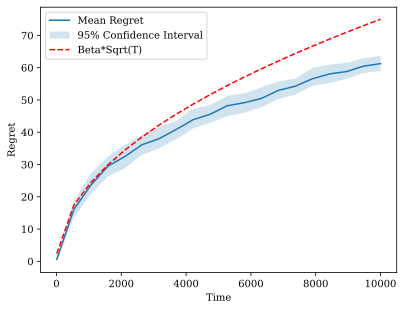

In [74]:
# Take the 2.5th percentile and 97.5th percentile
percentile_2_5 = np.percentile(pc_regrets, 2.5, axis=0)
percentile_97_5 = np.percentile(pc_regrets, 97.5, axis=0)

# Plot the mean regret and the 95% confidence interval
plt.plot(time, np.mean(pc_regrets, axis=0), label='Mean Regret')
plt.fill_between(time, percentile_2_5, percentile_97_5, alpha=0.2, label='95% Confidence Interval')
plt.xlabel('Time')
plt.ylabel('Regret')
#plt.title('Partitioned Contexts with Triangle Wave Function, L=5')
# Plot sqrt(T) function in red
plt.plot(time, 0.75*np.sqrt(time), 'r--', label='Beta*Sqrt(T)')
plt.legend()
plt.show()

In [ ]:
time = np.linspace(10, 10000, 20, dtype=int)
L_constants = [5]

# Some cool parallel computation trick
def compute_regret():
    _, _, regret = compute_scaling_laws_with_policy_regret(
        ExploitNearestContext, OrderBookEnvironment, time, L_constants, 
        construct_sequence_with_lipschitz_valuations, Lipschitz_function=triangle_wave_function
        )
    return regret

num_iterations = 100
enc_regrets = Parallel(n_jobs=-1)(delayed(compute_regret)() for _ in range(num_iterations))

In [67]:
# with open('../data/enc_tw.pkl', 'wb') as f: # enc_lb stands for Exploit Nearest Context with Triangle Wave Valuations
#     pickle.dump(enc_regrets, f)
with open('../data/enc_tw.pkl', 'rb') as f:
    enc_regrets = pickle.load(f)

# Transform to array
enc_regrets = np.array(enc_regrets).squeeze()
print(enc_regrets.shape)

(100, 20)


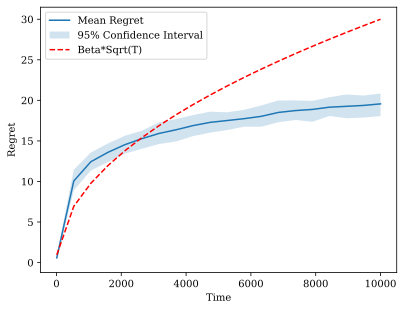

In [72]:
# Take the 2.5th percentile and 97.5th percentile
percentile_2_5 = np.percentile(enc_regrets, 2.5, axis=0)
percentile_97_5 = np.percentile(enc_regrets, 97.5, axis=0)

# Plot the mean regret and the 95% confidence interval
plt.plot(time, np.mean(enc_regrets, axis=0), label='Mean Regret')
plt.fill_between(time, percentile_2_5, percentile_97_5, alpha=0.2, label='95% Confidence Interval')
plt.xlabel('Time')
plt.ylabel('Regret')
#plt.title('Exploit Nearest Context with Triangle Wave Function, L=5')
# Plot sqrt(T) function in red
plt.plot(time, 0.3*np.sqrt(time), 'r--', label='Beta*Sqrt(T)')
plt.legend()
plt.show()

## Real Market Data

In [26]:
df = pd.read_csv(str(Path.cwd().parent) + "/data/AMN_book.csv")
df.head()

,time,1_bid_price,1_bid_vol,1_ask_price,1_ask_vol,2_bid_price,2_bid_vol,2_ask_price,2_ask_vol,3_bid_price,...,3_ask_price,3_ask_vol,4_bid_price,4_bid_vol,4_ask_price,4_ask_vol,5_bid_price,5_bid_vol,5_ask_price,5_ask_vol
0,34200421487235,33.83,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,34200421511022,33.83,100.0,58.1,100.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,34201025420728,46.06,300.0,58.1,100.0,33.83,100.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,34201028423195,46.06,300.0,58.1,100.0,33.83,200.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,34201028432288,46.06,300.0,58.1,200.0,33.83,200.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
s_dot = df["1_bid_price"]
b_dot = df["1_ask_price"]
max_price = max(s_dot.max(), b_dot.max())
min_price = min(s_dot.min(), b_dot.min())
print(max_price, min_price)

58.1 33.83


In [5]:
s_dot = (s_dot - min_price) / (max_price - min_price)
b_dot = (b_dot - min_price) / (max_price - min_price)
s_dot = s_dot.fillna(0).values
b_dot = b_dot.fillna(1).values
order_book = np.column_stack((s_dot, b_dot))
print(order_book.shape)

(2262, 2)


In [6]:
valuation_sequence = easy_function(s_dot, b_dot)
valuation_sequence = np.stack(valuation_sequence).T
print(valuation_sequence.shape)

(2262, 2)


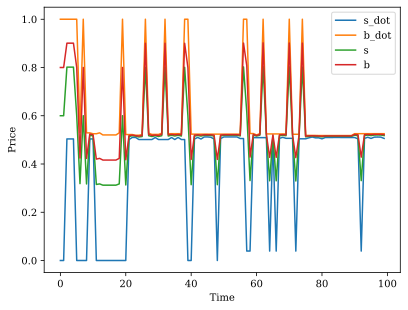

In [7]:
# Plot s_dot and b_dot, valuation_sequence
plt.plot(s_dot[:100], label="s_dot")
plt.plot(b_dot[:100], label="b_dot")
plt.plot(valuation_sequence[:100, 0], label="s")
plt.plot(valuation_sequence[:100, 1], label="b")
plt.legend()
plt.xlabel("Time")
plt.ylabel("Price")
plt.show()

In [8]:
T = order_book.shape[0]
L = 1
env = OrderBookEnvironment(T, order_book, valuation_sequence)
algo = PartitionedContexts(T, env, L)
algo.run()

print(env.get_policy_gft_having_adhoc_valuations())
print(algo.get_final_gft())

100%|██████████| 2262/2262 [00:00<00:00, 241234.60it/s]

78.60115368768025
75.29847548413676


In [9]:
T = order_book.shape[0]
L = 1
env = OrderBookEnvironment(T, order_book, valuation_sequence)
algo = ExploitNearestContext(T, env, L)
algo.run()

print(env.get_policy_gft_having_adhoc_valuations())
print(algo.get_final_gft())

100%|██████████| 2261/2261 [00:00<00:00, 23495.32it/s]

78.60115368768025
78.0707869798102


In [10]:
# Build a dummy sequence constructor to return order_book and valuation_sequence from the global scope
def dummy_sequence_constructor(T, L, *args, **kwargs):
    return order_book[:T], valuation_sequence[:T]

In [ ]:
time = np.linspace(10, 2262, 20, dtype=int)
L_constants = [1]

# Some cool parallel computation trick
def compute_regret():
    _, _, regret = compute_scaling_laws_with_policy_regret(
        PartitionedContexts, OrderBookEnvironment, time, L_constants, 
        dummy_sequence_constructor, Lipschitz_function=None
        )
    return regret

num_iterations = 100
pc_regrets = Parallel(n_jobs=-1)(delayed(compute_regret)() for _ in range(num_iterations))

In [12]:
# with open('../data/pc_nasdaq.pkl', 'wb') as f: # pc_lb stands for Partitioned Contexts with NASDAQ data
#     pickle.dump(pc_regrets, f)
with open('../data/pc_nasdaq.pkl', 'rb') as f:
    pc_regrets = pickle.load(f)

# Transform to array
pc_regrets = np.array(pc_regrets).squeeze()
print(pc_regrets.shape)

(100, 20)


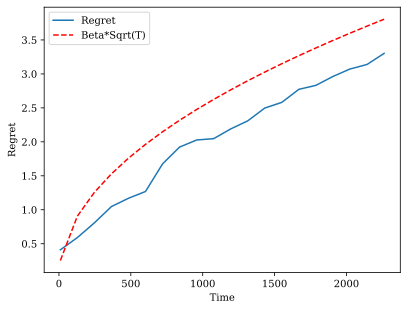

In [15]:
# Take the 2.5th percentile and 97.5th percentile
percentile_2_5 = np.percentile(pc_regrets, 2.5, axis=0)
percentile_97_5 = np.percentile(pc_regrets, 97.5, axis=0)

# Plot the mean regret and the 95% confidence interval
plt.plot(time, np.mean(pc_regrets, axis=0), label='Regret')
#plt.fill_between(time, percentile_2_5, percentile_97_5, alpha=0.2, label='95% Confidence Interval')
plt.xlabel('Time')
plt.ylabel('Regret')
#plt.title('Partitioned Contexts with NASDAQ Data')
# Plot sqrt(T) function in red
plt.plot(time, 0.08*np.sqrt(time), 'r--', label='Beta*Sqrt(T)')
plt.legend()
plt.show()

In [ ]:
time = np.linspace(10, 2262, 20, dtype=int)
L_constants = [1]

# Some cool parallel computation trick
def compute_regret():
    _, _, regret = compute_scaling_laws_with_policy_regret(
        ExploitNearestContext, OrderBookEnvironment, time, L_constants, 
        dummy_sequence_constructor, Lipschitz_function=None
        )
    return regret

num_iterations = 100
enc_regrets = Parallel(n_jobs=-1)(delayed(compute_regret)() for _ in range(num_iterations))

In [17]:
# with open('../data/enc_nasdaq.pkl', 'wb') as f: # enc_lb stands for Exploit Nearest Context with NASDAQ data
#     pickle.dump(enc_regrets, f)
with open('../data/enc_nasdaq.pkl', 'rb') as f:
    enc_regrets = pickle.load(f)

# Transform to array
enc_regrets = np.array(enc_regrets).squeeze()
print(enc_regrets.shape)

(100, 20)


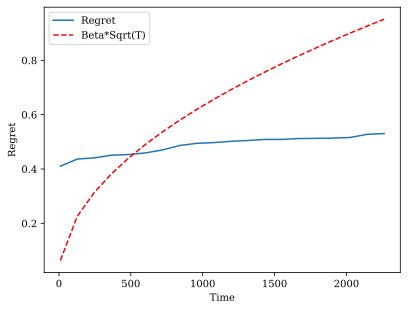

In [21]:
# Take the 2.5th percentile and 97.5th percentile
percentile_2_5 = np.percentile(enc_regrets, 2.5, axis=0)
percentile_97_5 = np.percentile(enc_regrets, 97.5, axis=0)

# Plot the mean regret and the 95% confidence interval
plt.plot(time, np.mean(enc_regrets, axis=0), label='Regret')
#plt.fill_between(time, percentile_2_5, percentile_97_5, alpha=0.2, label='95% Confidence Interval')
plt.xlabel('Time')
plt.ylabel('Regret')
#plt.title('Exploit Nearest Context with NASDAQ Data')
# Plot sqrt(T) function in red
plt.plot(time, 0.02*np.sqrt(time), 'r--', label='Beta*Sqrt(T)')
plt.legend()
plt.show()